# Low-Rank RNN

Discrete RNN :

$$
\dot h_i(t) = -h_i(t) + \sum_j J_{ij} \phi(h_j(t)) + I^{\mathrm{ext}}_i(t) \\
J_{ij} = \sum_{\mu=1}^p f_\mu(\vec{z_i}) g_\mu(\vec{z_j})
$$

Neural field equations :

$$
\dot h(t, \vec z) = -h(t, \vec z) + \int \rho(\vec y) \sum_{\mu=1}^p f_\mu(\vec{z}) g_\mu(\vec{z}) \phi(h(t, \vec y)) \; \mathrm d y
$$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt, matplotlib.animation as animation
import numpy as np
from neurodyn import *
from utils import *

### Optimal einsum path

first do the sum on the patterns, then on the neurons

In [20]:
F, G = make_F_G_valentin(p=1, N=10_000_000, phi=sigmoid, random_state=42)
rate = sigmoid(F[:, 0])

# main sum
path_info = np.einsum_path('im,jm,j->i', F, G, rate, optimize='optimal')
print(path_info[0])
print(path_info[1])

# removing self-connections
path_info = np.einsum_path('im,im,i->i', F, G, rate, optimize='optimal')
print(path_info[0])
print(path_info[1])

['einsum_path', (1, 2), (0, 1)]
  Complete contraction:  im,jm,j->i
         Naive scaling:  3
     Optimized scaling:  2
      Naive FLOP count:  3.000e+14
  Optimized FLOP count:  4.000e+07
   Theoretical speedup:  7499999.813
  Largest intermediate:  1.000e+07 elements
--------------------------------------------------------------------------
scaling                  current                                remaining
--------------------------------------------------------------------------
   2                     j,jm->m                                  im,m->i
   2                     m,im->i                                     i->i
['einsum_path', (0, 1), (0, 1)]
  Complete contraction:  im,im,i->i
         Naive scaling:  2
     Optimized scaling:  2
      Naive FLOP count:  3.000e+07
  Optimized FLOP count:  3.000e+07
   Theoretical speedup:  1.000
  Largest intermediate:  1.000e+07 elements
--------------------------------------------------------------------------
scaling      

## Ensure the low-rank formulation is the same as the explicit connectivity matrix

-- connectivity matrices --
[[ 0.   -0.41 -0.45 ... -0.3   0.43 -0.13]
 [-0.48  0.    0.91 ...  0.61 -0.86  0.27]
 [-0.55  0.96  0.   ...  0.7  -0.99  0.31]
 ...
 [-0.31  0.54  0.59 ...  0.   -0.56  0.17]
 [ 0.5  -0.88 -0.96 ... -0.64  0.   -0.28]
 [-0.13  0.22  0.24 ...  0.16 -0.23  0.  ]]
[[ 0.24 -0.41 -0.45 ... -0.3   0.43 -0.13]
 [-0.48  0.84  0.91 ...  0.61 -0.86  0.27]
 [-0.55  0.96  1.05 ...  0.7  -0.99  0.31]
 ...
 [-0.31  0.54  0.59 ...  0.39 -0.56  0.17]
 [ 0.5  -0.88 -0.96 ... -0.64  0.91 -0.28]
 [-0.13  0.22  0.24 ...  0.16 -0.23  0.07]]
-- distribution samples --
[-0.83  1.69  1.94  1.14  1.03 -1.26  0.04  0.32  1.12  1.35 -0.67  1.41
  0.68  1.09 -1.78  0.44]
[-0.83  1.69  1.94  1.14  1.03 -1.26  0.04  0.32  1.12  1.35 -0.67  1.41
  0.68  1.09 -1.78  0.44]
-- drives --
[-2.28  3.78  4.23  2.71  2.48 -3.44  0.11  0.82  2.66  3.12 -1.84  3.25
  1.7   2.61 -4.85  1.14]
[-2.28  3.78  4.23  2.71  2.48 -3.44  0.11  0.82  2.66  3.12 -1.84  3.25
  1.7   2.61 -4.85  1.14]


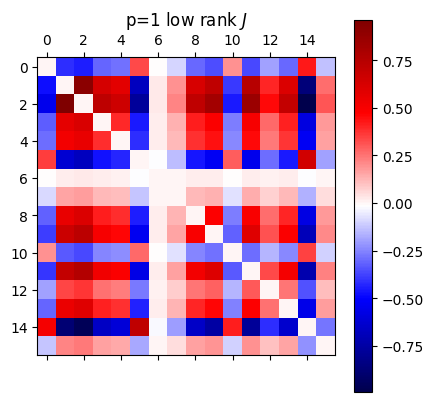

In [51]:
N = 16
J, z_samples = make_low_rank_valentin(p=1, N=N, phi=sigmoid, random_state=42, exclude_self_connections=True)
F, G = make_F_G_valentin(p=1, N=N, phi=sigmoid, random_state=42)

with np.printoptions(precision=2, suppress=True, threshold=80):
	print('-- connectivity matrices --')
	print(J)
	# note : we haven't removed the self-connections
	print((np.einsum('im,jm->ij', F, G)) / N)

	print('-- distribution samples --')
	print(F.squeeze())
	print(z_samples[0])

	print('-- drives --')
	rate = sigmoid(z_samples[0])
	print(J @ rate)
	drive = np.zeros_like(rate)
	drive += np.einsum('im,jm,j->i', F, G, rate)
	drive -= np.einsum('im,im,i->i', F, G, rate)
	drive /= N
	print(drive)

im = plt.matshow(J, cmap='seismic')
plt.colorbar(im)
plt.title('p=1 low rank $J$')
plt.show()

[N=64 DiscreteRNN simulation] 63.69519233703613 ms
[N=64 LowRankRNN simulation] 235.9938621520996 ms


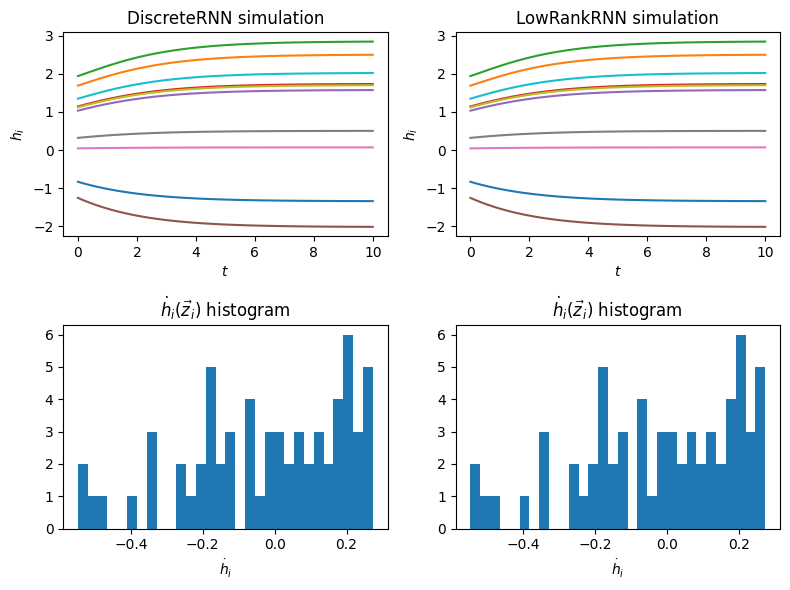

[N=128 DiscreteRNN simulation] 212.5084400177002 ms
[N=128 LowRankRNN simulation] 463.31000328063965 ms


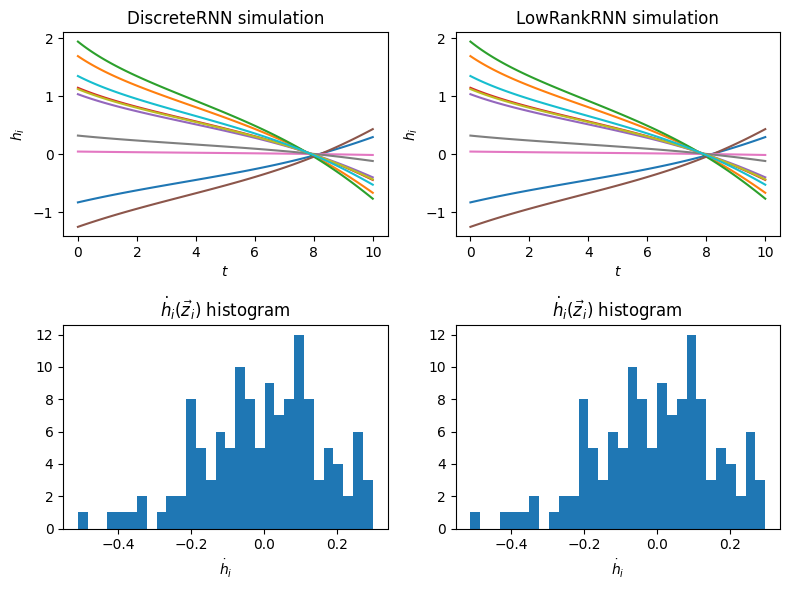

[N=256 DiscreteRNN simulation] 253.99112701416016 ms
[N=256 LowRankRNN simulation] 485.8579635620117 ms


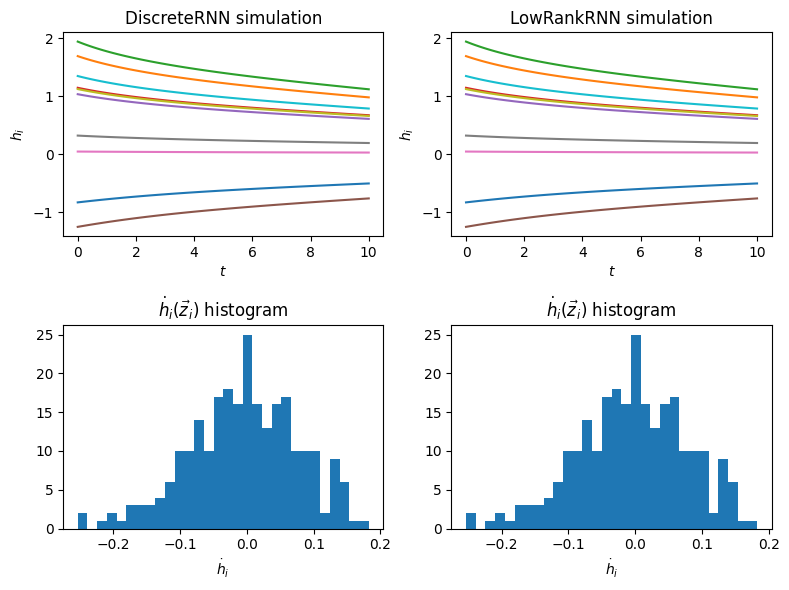

[N=512 DiscreteRNN simulation] 1102.4479866027832 ms
[N=512 LowRankRNN simulation] 495.5594539642334 ms


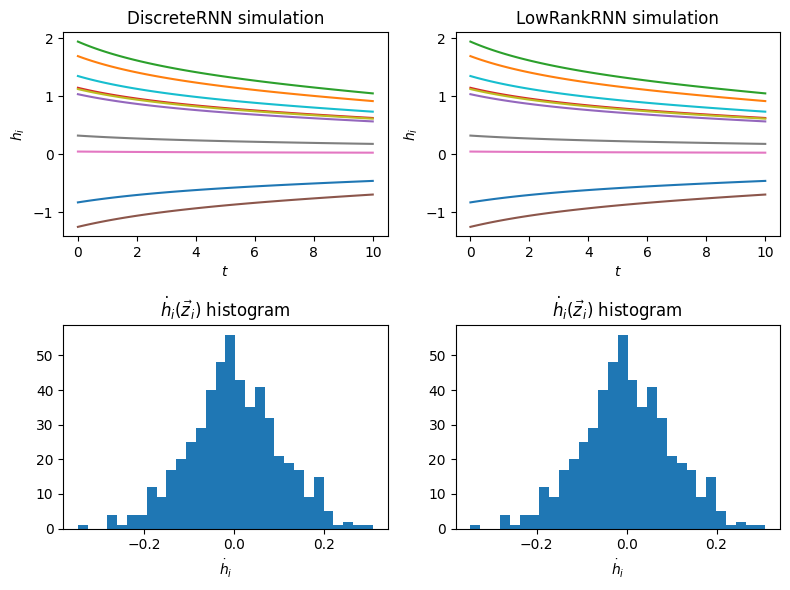

In [18]:
for N in [64, 128, 256, 512]:
	phi = sigmoid
	I_ext = lambda t: 0
	J, z_samples = make_low_rank_valentin(p=1, N=N, phi=phi, random_state=42, exclude_self_connections=True)
	F, G = make_F_G_valentin(p=1, N=N, phi=phi, random_state=42)

	rnn_full = DiscreteRNN(J, phi, I_ext)
	rnn_lr = LowRankRNN(F, G, phi, I_ext, exclude_self_connections=True)
	
	with Timer(name=f'{N=} DiscreteRNN simulation'):
		res_full = rnn_full.simulate_h(h0=z_samples[0], t_span=(0, 10))
	with Timer(name=f'{N=} LowRankRNN simulation'):
		res_lr = rnn_lr.simulate_h(h0=z_samples[0], t_span=(0, 10))

	fig, ax = plt.subplots(ncols=2, nrows=2, figsize=(8, 6), tight_layout=True)
	ax[0, 0].set_title('DiscreteRNN simulation')
	ax[0, 0].set_xlabel('$t$')
	ax[0, 0].set_ylabel('$h_i$')
	for i in range(10):
		ax[0, 0].plot(res_full.t, res_full.y[i, :])
	ax[0, 1].set_title('LowRankRNN simulation')
	ax[0, 1].set_xlabel('$t$')
	ax[0, 1].set_ylabel('$h_i$')
	for i in range(10):
		ax[0, 1].plot(res_lr.t, res_lr.y[i, :])
	ax[1, 0].hist(rnn_full.dh(0, z_samples[0]), bins=30)
	ax[1, 0].set_title('$\\dot h_i(\\vec z_i)$ histogram')
	ax[1, 0].set_xlabel('$\\dot h_i$')
	ax[1, 1].hist(rnn_lr.dh(0, z_samples[0]), bins=30)
	ax[1, 1].set_title('$\\dot h_i(\\vec z_i)$ histogram')
	ax[1, 1].set_xlabel('$\\dot h_i$')
	plt.show()

## Are the $\vec{z_i}$ stationary points ?

[N=1000 LowRankRNN simulation] 117.27261543273926 ms
[N=5000 LowRankRNN simulation] 562.7641677856445 ms
[N=10000 LowRankRNN simulation] 1729.538917541504 ms
[N=50000 LowRankRNN simulation] 5226.054430007935 ms


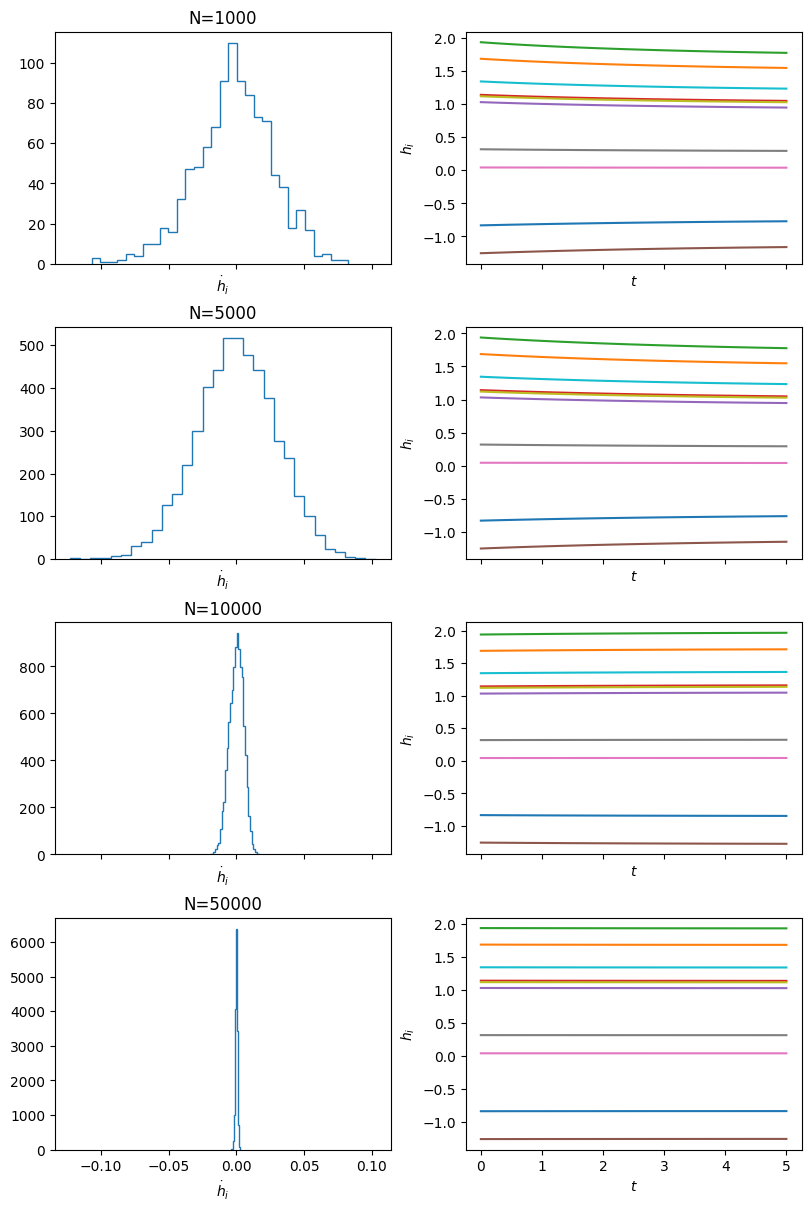

In [16]:
Ns = [1000, 5000, 10_000, 50_000]
fig, ax = plt.subplots(ncols=2, nrows=len(Ns), figsize=(8, 3*len(Ns)), sharex='col', constrained_layout=True)

for i, N in enumerate(Ns):
	I_ext = lambda t: 0
	phi = sigmoid
	F, G = make_F_G_valentin(p=1, N=N, phi=phi, random_state=42)
	rnn = LowRankRNN(F, G, phi, I_ext, exclude_self_connections=True)
	with Timer(name=f'{N=} LowRankRNN simulation'):
		res = rnn.simulate_h(h0=F[:, 0], t_span=(0, 5))

	ax[i, 0].hist(rnn.dh(0, F[:, 0]), bins=30, histtype='step')
	ax[i, 0].set_title(f'{N=}')
	ax[i, 0].set_xlabel('$\\dot h_i$')
	for n in range(10):
		ax[i, 1].plot(res.t, res.y[n, :])
	ax[i, 1].set_xlabel('$t$')
	ax[i, 1].set_ylabel('$h_i$')

plt.show()

## Embedding in $d=1$ (one pattern, $p=1$)

~~Start the neurons close to the known fixed point $\xi^1_i$~~

Actually it looks like if there are enough neurons, we can just start them from zero

In [112]:
rnn = LowRankRNN(*make_F_G_valentin(p=1, N=50_000, phi=phi, random_state=42), phi, I_ext, exclude_self_connections=True)
with Timer(name=f'{N=} LowRankRNN simulation'):
	# res = rnn.simulate_h(h0=rnn.F[:, 0], t_span=(0, 5))
	# + np.random.default_rng(42).normal(loc=0, scale=0.1, size=rnn.N)
	res = rnn.simulate_h(h0=np.zeros(rnn.N), t_span=(0, 40))

[N=512 LowRankRNN simulation] 45331.00 ms


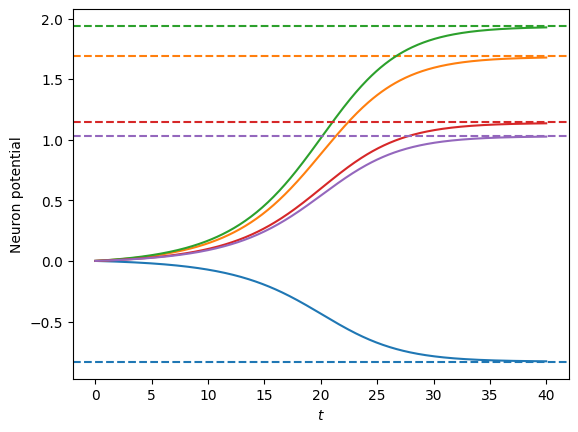

In [116]:
# full lines are the neuron trajectory
# dashed lines are the xi_i fixed point

fig, ax = plt.subplots()

for n in range(5):
	line, = ax.plot(res.t, res.y[n, :])
	ax.axhline(rnn.F[n, 0], color=line.get_color(), linestyle='--')

ax.set_xlabel('$t$')
ax.set_ylabel('Neuron potential')
plt.show()

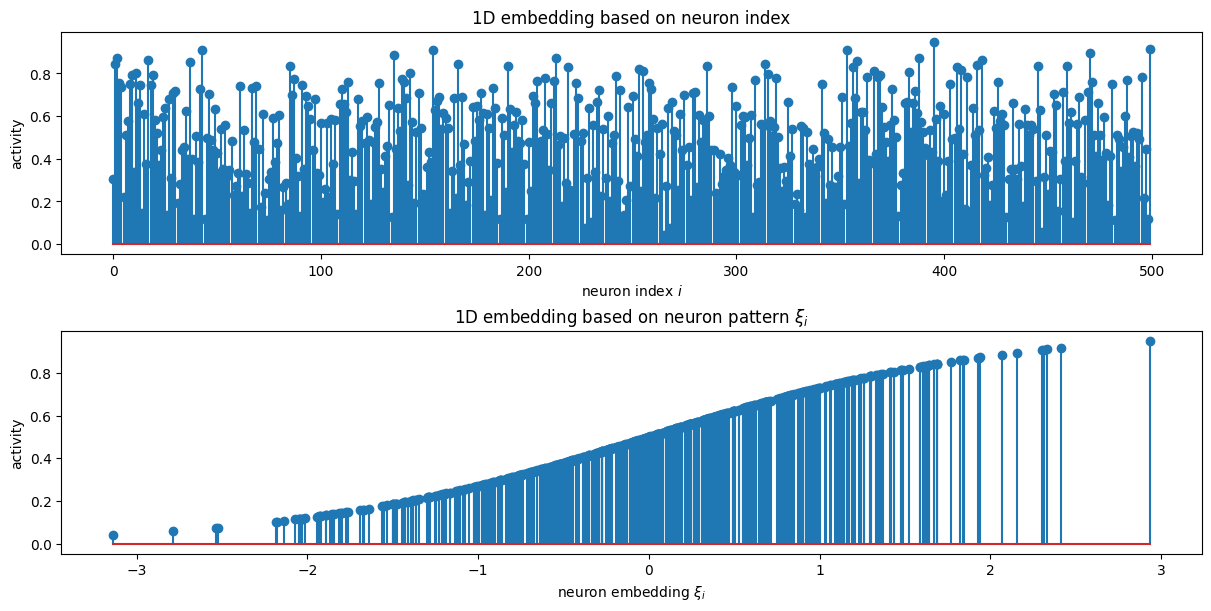

In [120]:
# we plot only the first 500 neurons because otherwise it gets really slow

fig, ax = plt.subplots(figsize=(12, 6), nrows=2, constrained_layout=True)

ax[0].set_title('1D embedding based on neuron index')
ax[0].stem(np.arange(len(res.y[:500, -1])), rnn.phi(res.y[:500, -1]))
ax[0].set_xlabel('neuron index $i$')
ax[0].set_ylabel('activity')

# at the fixed point, all neurons are in state Xi_i, so the activity follows Phi(Xi)
ax[1].set_title('1D embedding based on neuron pattern $\\xi_i$')
ax[1].stem(rnn.F[:500, 0], rnn.phi(res.y[:500, -1]))
ax[1].set_xlabel('neuron embedding $\\xi_i$')
ax[1].set_ylabel('activity')

plt.show()

In [131]:
fig, ax = plt.subplots(figsize=(12, 6), nrows=2, constrained_layout=True)
Nmax = 256

ax[0].set_title('1D embedding based on neuron index')
stem1 = ax[0].stem(np.arange(len(res.y[:Nmax, 0])), rnn.phi(res.y[:Nmax, 0]))
ax[0].set_xlabel('neuron index $i$')
ax[0].set_ylabel('activity')
ax[0].set_ylim((0, 1))

ax[1].set_title('1D embedding based on neuron pattern $\\xi_i$')
stem2 = ax[1].stem(rnn.F[:Nmax, 0], rnn.phi(res.y[:Nmax, 0]))
ax[1].set_xlabel('neuron embedding $\\xi_i$')
ax[1].set_ylabel('activity')
ax[1].set_ylim((0, 1))

def update(idt: int):
	print(idt)
	activity = rnn.phi(res.y[:Nmax, idt])
	embed_index = np.arange(len(res.y[:Nmax, 0]))
	embed_gauss = rnn.F[:Nmax, 0]
	stem1.markerline.set_ydata(activity)
	stem2.markerline.set_ydata(activity)
	stem1.stemlines.set_paths([np.array([[x, 0], [x, y]]) for x, y in zip(embed_index, activity)])
	stem2.stemlines.set_paths([np.array([[x, 0], [x, y]]) for x, y in zip(embed_gauss, activity)])
	# return *stem1, *stem2

ani = animation.FuncAnimation(fig, update, frames=range(0, len(res.t), 10))
ani.save('d=1 embedding.mp4', writer='ffmpeg', fps=30)

plt.close(fig)

0
0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400


## Embedding in $d=2$ (two patterns)

cycling patterns

## TODO

- cleanup animation writer
- have a way to save the params into a string/json representation (for reproducibility)
- I_ext as Weiner process